In [3]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math

In [4]:
df = pd.read_csv('GOOG.csv', parse_dates=['Date'])
print(df.head())
print(df.tail())
print(df.shape)
print(df.columns)


        Date         Open         High          Low        Close    Adj Close  \
0 2017-11-20  1020.260010  1022.609985  1017.500000  1018.380005  1018.380005   
1 2017-11-21  1023.309998  1035.109985  1022.655029  1034.489990  1034.489990   
2 2017-11-22  1035.000000  1039.706055  1031.430054  1035.959961  1035.959961   
3 2017-11-24  1035.869995  1043.177979  1035.000000  1040.609985  1040.609985   
4 2017-11-27  1040.000000  1055.459961  1038.439941  1054.209961  1054.209961   

    Volume  
0   953500  
1  1097000  
2   746300  
3   537000  
4  1307900  
           Date         Open         High          Low        Close  \
1042 2022-01-11  2763.610107  2806.590088  2736.270020  2800.350098   
1043 2022-01-12  2831.090088  2856.284912  2822.239990  2832.959961   
1044 2022-01-13  2836.810059  2863.709961  2778.280029  2782.620117   
1045 2022-01-14  2750.000000  2824.010010  2750.000000  2795.729980   
1046 2022-01-18  2732.000000  2747.830078  2712.340088  2725.810059   

        

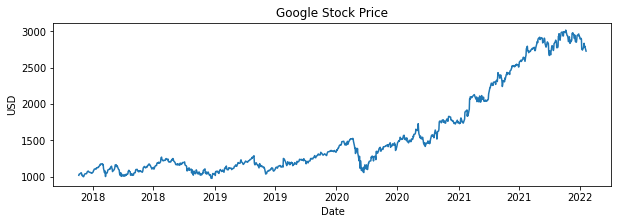

In [5]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df['Date'], df['Close'], label='Google stock')
ax.set(xlabel="Date",
       ylabel="USD",
       title="Google Stock Price")
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
plt.show()

In [6]:
def get_technical_indicators(data):
    # Create 7 and 21 days Moving Average
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean()
    data['MA21'] = data.iloc[:,4].rolling(window=21).mean()

    # Create MACD
    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA21'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA21'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data

In [7]:
T_df = get_technical_indicators(df)

In [8]:
dataset = T_df.iloc[20:,:].reset_index(drop=True)

In [10]:
def get_fourier_transfer(dataset):
    # Get the columns for doing fourier
    data_FT = dataset[['Date', 'Close']]

    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    fft_df = pd.DataFrame({'fft': close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_com_df = pd.DataFrame()
    for num_ in [3, 6, 9]:
        fft_list_m10 = np.copy(fft_list);
        fft_list_m10[num_:-num_] = 0
        fft_ = np.fft.ifft(fft_list_m10)
        fft_com = pd.DataFrame({'fft': fft_})
        fft_com['absolute of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.abs(x))
        fft_com['angle of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.angle(x))
        fft_com = fft_com.drop(columns='fft')
        fft_com_df = pd.concat([fft_com_df, fft_com], axis=1)

    return fft_com_df

In [11]:
dataset_F = get_fourier_transfer(dataset)
Final_data = pd.concat([dataset, dataset_F], axis=1)

In [12]:
print(Final_data.head())
Final_data.to_csv("GOOG_Finaldata_with_Fourier.csv", index=False)

        Date         Open         High          Low        Close    Adj Close  \
0 2017-12-19  1075.199951  1076.839966  1063.550049  1070.680054  1070.680054   
1 2017-12-20  1071.780029  1073.380005  1061.520020  1064.949951  1064.949951   
2 2017-12-21  1064.949951  1069.329956  1061.793945  1063.630005  1063.630005   
3 2017-12-22  1061.109985  1064.199951  1059.439941  1060.119995  1060.119995   
4 2017-12-26  1058.069946  1060.119995  1050.199951  1056.739990  1056.739990   

    Volume          MA7         MA21      MACD  ...   upper_band  lower_band  \
0  1338700  1054.764282  1036.087617 -3.786515  ...  1077.545258  994.629977   
1  1268600  1058.171421  1038.305234 -5.723333  ...  1081.577079  995.033389   
2   995700  1061.478568  1039.692854 -6.327494  ...  1084.369835  995.015872   
3   755100  1064.265712  1040.843331 -6.466375  ...  1086.430188  995.256474   
4   760600  1065.349993  1041.611427 -6.340926  ...  1087.368049  995.854805   

           EMA  logmomentum  abs

In [13]:
def plot_technical_indicators(dataset, last_days):
       plt.figure(figsize=(16, 10), dpi=100)
       shape_0 = dataset.shape[0]
       xmacd_ = shape_0 - last_days

       dataset = dataset.iloc[-last_days:, :]
       x_ = range(3, dataset.shape[0])
       x_ = list(dataset.index)

       # Plot first subplot
       plt.subplot(2, 1, 1)
       plt.plot(dataset['MA7'], label='MA 7', color='g', linestyle='--')
       plt.plot(dataset['Close'], label='Closing Price', color='b')
       plt.plot(dataset['MA21'], label='MA 21', color='r', linestyle='--')
       plt.plot(dataset['upper_band'], label='Upper Band', color='c')
       plt.plot(dataset['lower_band'], label='Lower Band', color='c')
       plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
       plt.title('Technical indicators for Apple - last {} days.'.format(last_days))
       plt.ylabel('USD')
       plt.legend()

       # Plot second subplot
       plt.subplot(2, 1, 2)
       plt.title('MACD')
       plt.plot(dataset['MACD'], label='MACD', linestyle='-.')
       plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
       plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
       plt.plot(dataset['logmomentum'], label='Momentum', color='b', linestyle='-')
       
       plt.legend()
       plt.show()

In [14]:
plot_technical_indicators(T_df, 400)

In [15]:
def plot_Fourier(dataset):
    data_FT = dataset[['Date', 'Close']]

    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    fft_df = pd.DataFrame({'fft': close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft_df['fft'].tolist())
    plt.figure(figsize=(14, 7), dpi=100)
    fft_list = np.asarray(fft_df['fft'].tolist())
    for num_ in [3, 6, 9]:
        fft_list_m10 = np.copy(fft_list);
        fft_list_m10[num_:-num_] = 0
        plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
    plt.plot(data_FT['Close'], label='Real')
    plt.xlabel('Days')
    plt.ylabel('USD')
    plt.title('Apple (close) stock prices & Fourier transforms')
    plt.legend()
    plt.show()

In [16]:
plot_Fourier(dataset)

c:\Users\simon\Desktop\price_predict_god\my-python-app\Pforproject\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\simon\Desktop\price_predict_god\my-python-app\Pforproject\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\simon\Desktop\price_predict_god\my-python-app\Pforproject\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
